In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [5]:
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [6]:
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


In [7]:
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [9]:
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

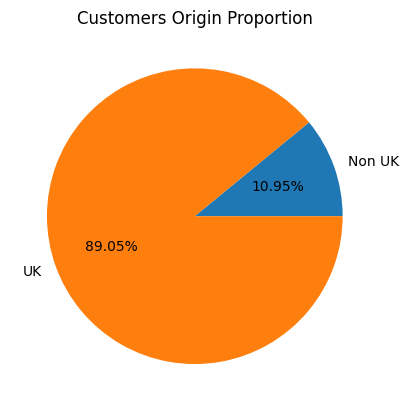

In [10]:
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

In [11]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


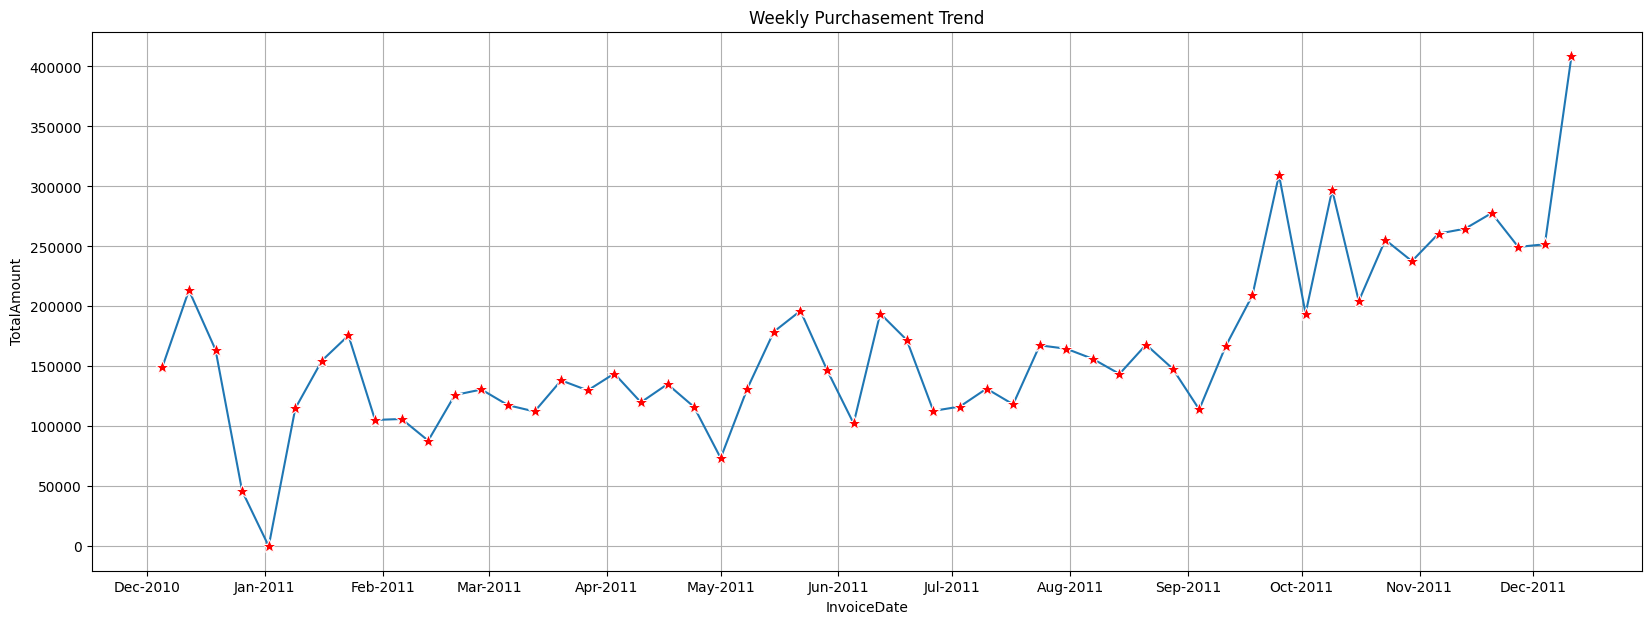

In [12]:
import matplotlib.dates as mdates

weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

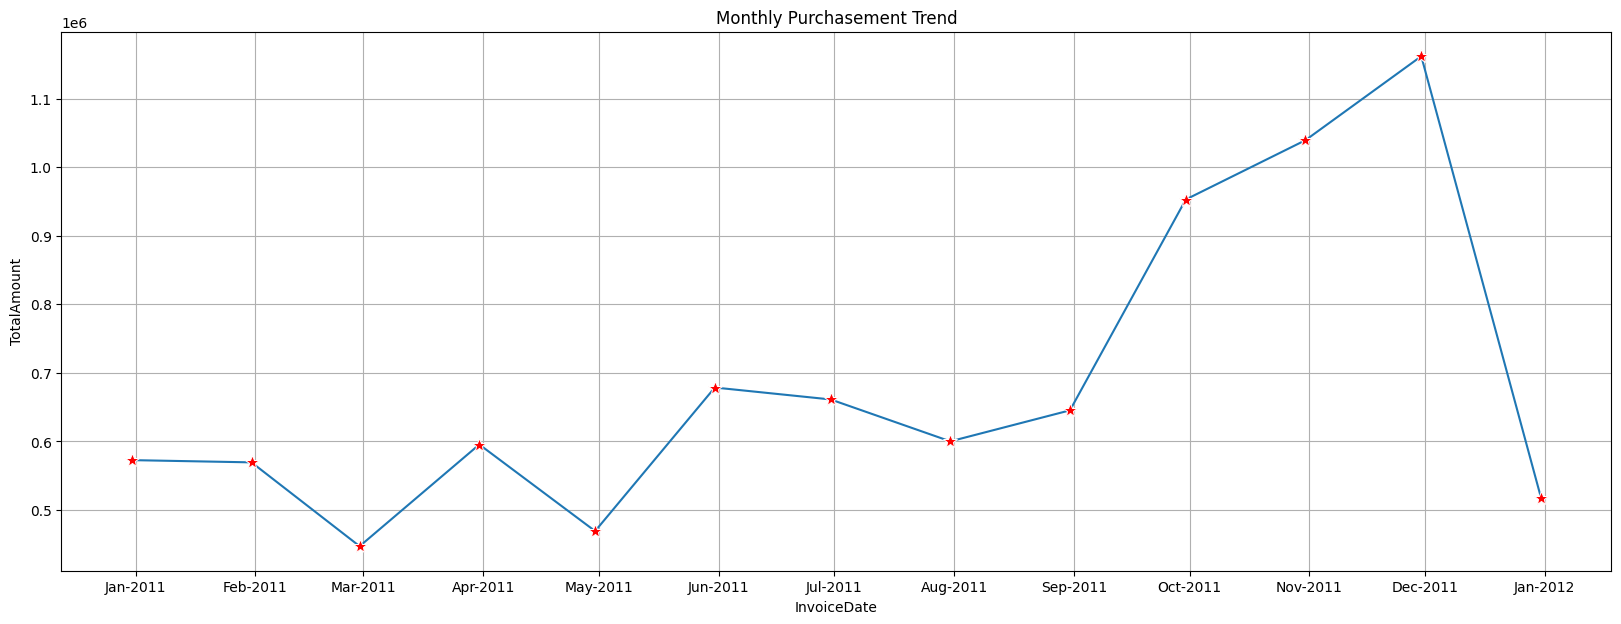

In [13]:
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

In [14]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

NameError: ignored

<Figure size 1200x700 with 0 Axes>

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

In [ ]:
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method

# Merge the data
df_new = (

)

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

In [ ]:
df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

In [ ]:
sns.boxplot(data=df_new)
plt.show()

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

In [ ]:
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

In [ ]:
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

In [ ]:
kmeans = KMeans(n_clusters=6,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Frequency"].count()

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Monetary"].count()

**No.1**

In [25]:
total_purchase = df.groupby('CustomerID')['TotalAmount'].sum().reset_index()

# Finding the customer who purchased the most
customer_with_max_purchase = total_purchase.loc[total_purchase['TotalAmount'].idxmax()]

print("CustomerID:", customer_with_max_purchase['CustomerID'])
print("Total Purchase Amount:", customer_with_max_purchase['TotalAmount'])

CustomerID: 14646.0
Total Purchase Amount: 280206.02


In [29]:
total_purchase = df.groupby('CustomerID')['TotalAmount'].sum().reset_index()

sorted_customers = total_purchase.sort_values(by='TotalAmount', ascending=False)

top_5_customers = sorted_customers.head(5)

print(top_5_customers)

      CustomerID  TotalAmount
1689     14646.0    280206.02
4201     18102.0    259657.30
3728     17450.0    194550.79
3008     16446.0    168472.50
1879     14911.0    143825.06


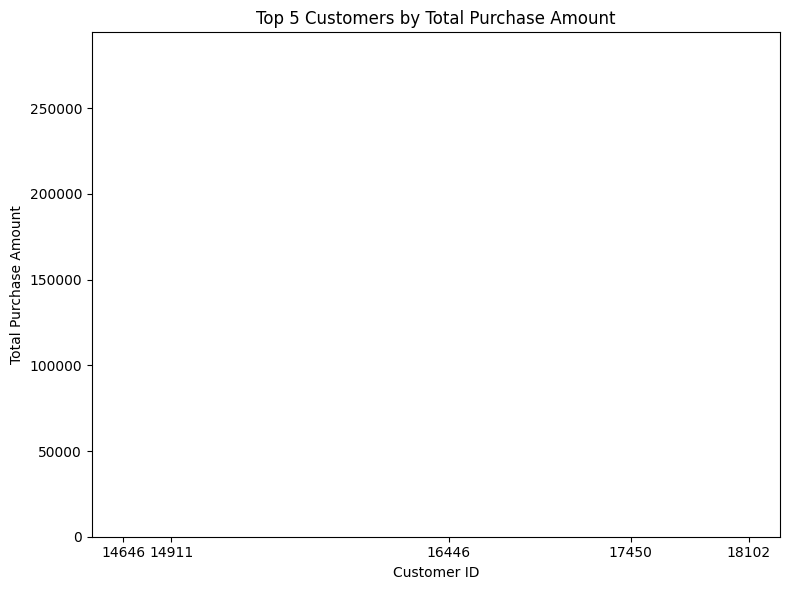

In [37]:
plt.figure(figsize=(8, 6))
plt.bar(top_5_customers['CustomerID'], top_5_customers['TotalAmount'], color='skyblue')
plt.xlabel('Customer ID')
plt.ylabel('Total Purchase Amount')
plt.title('Top 5 Customers by Total Purchase Amount')
plt.xticks(top_5_customers['CustomerID'])
plt.tight_layout()

plt.show()

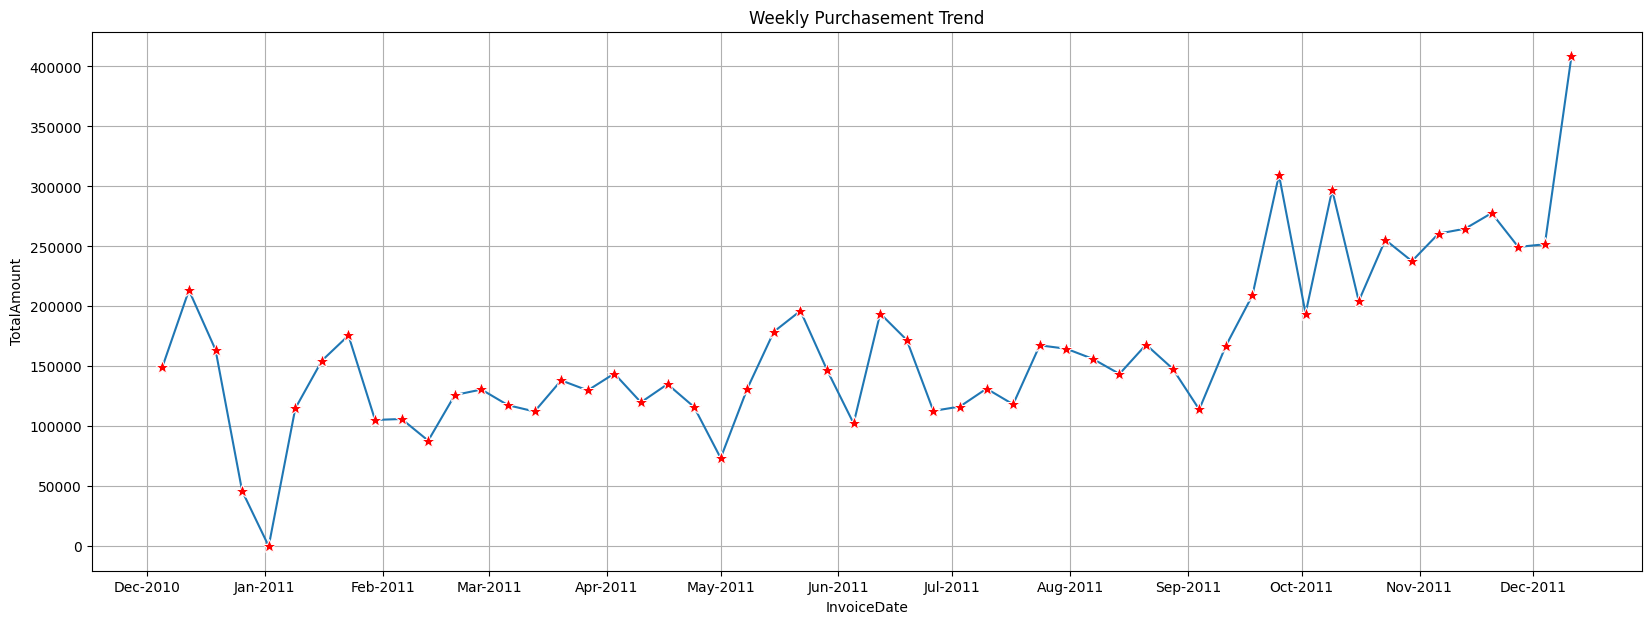

In [38]:
import matplotlib.dates as mdates

weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

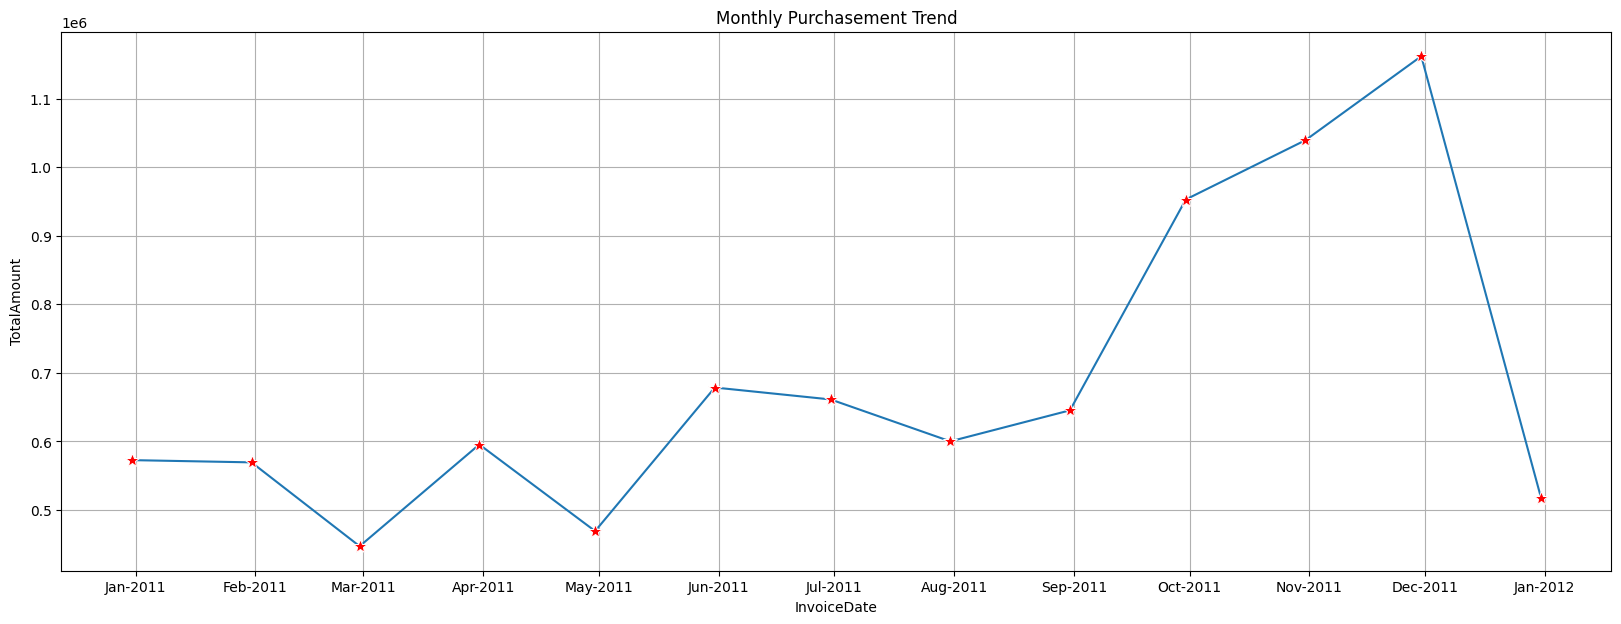

In [39]:
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

**No.2**

In [40]:
df['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [41]:
df['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     2028
REGENCY CAKESTAND 3 TIER               1723
JUMBO BAG RED RETROSPOT                1618
ASSORTED COLOUR BIRD ORNAMENT          1408
PARTY BUNTING                          1396
LUNCH BAG RED RETROSPOT                1316
SET OF 3 CAKE TINS PANTRY DESIGN       1159
LUNCH BAG  BLACK SKULL.                1105
POSTAGE                                1099
PACK OF 72 RETROSPOT CAKE CASES        1068
PAPER CHAIN KIT 50'S CHRISTMAS         1019
SPOTTY BUNTING                         1017
LUNCH BAG SPACEBOY DESIGN              1008
LUNCH BAG CARS BLUE                     989
HEART OF WICKER SMALL                   985
NATURAL SLATE HEART CHALKBOARD          980
LUNCH BAG PINK POLKADOT                 957
REX CASH+CARRY JUMBO SHOPPER            952
LUNCH BAG SUKI DESIGN                   933
ALARM CLOCK BAKELIKE RED                899
LUNCH BAG APPLE DESIGN                  895
SET OF 4 PANTRY JELLY MOULDS            893
JUMBO BAG PINK POLKADOT         

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


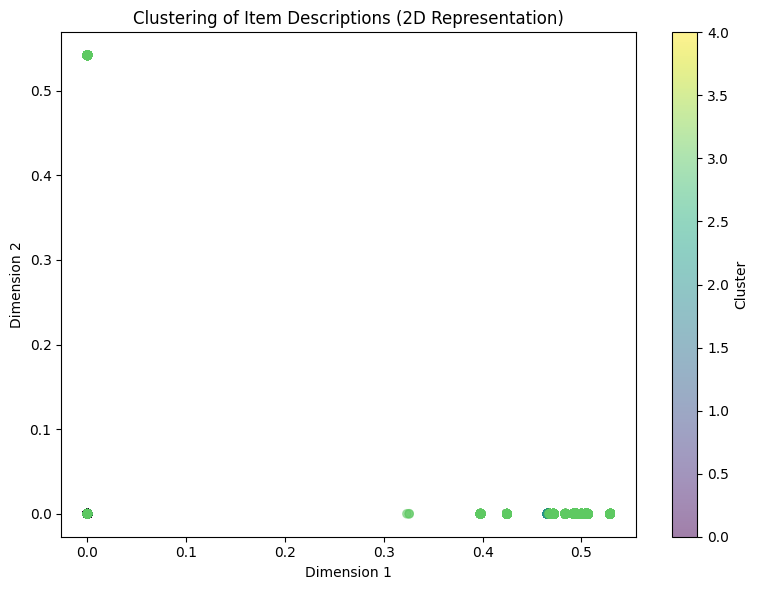

In [47]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Description'])

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

df['Cluster'] = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(X.toarray()[:, 0], X.toarray()[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Clustering of Item Descriptions (2D Representation)')
plt.colorbar(label='Cluster')
plt.tight_layout()

plt.show()

In [48]:
df['Cluster'].unique()

array([0, 3, 4, 2, 1], dtype=int32)

In [51]:
cluster_0_descriptions = df[df['Cluster'] == 0]['Description']
print("Descriptions in Cluster 0:")
print(cluster_0_descriptions)

Descriptions in Cluster 0:
0          WHITE HANGING HEART T-LIGHT HOLDER
6           GLASS STAR FROSTED T-LIGHT HOLDER
49         WHITE HANGING HEART T-LIGHT HOLDER
64          GLASS STAR FROSTED T-LIGHT HOLDER
66         WHITE HANGING HEART T-LIGHT HOLDER
81          GLASS STAR FROSTED T-LIGHT HOLDER
83           RED HANGING HEART T-LIGHT HOLDER
156       COLOUR GLASS T-LIGHT HOLDER HANGING
164                   CREAM HEART CARD HOLDER
188             FIVE HEART HANGING DECORATION
217         HANGING HEART ZINC T-LIGHT HOLDER
220        WHITE HANGING HEART T-LIGHT HOLDER
221                      SMALL POPCORN HOLDER
222                     LARGE POPCORN HOLDER 
262        WHITE HANGING HEART T-LIGHT HOLDER
264                   BLACK HEART CARD HOLDER
278        WHITE HANGING HEART T-LIGHT HOLDER
295         GLASS STAR FROSTED T-LIGHT HOLDER
364        WHITE HANGING HEART T-LIGHT HOLDER
393                      SMALL POPCORN HOLDER
416        WHITE HANGING HEART T-LIGHT HOLDER
432    

In [54]:
cluster_1_descriptions = df[df['Cluster'] == 1]['Description']
print("Descriptions in Cluster 1:")
print(cluster_1_descriptions)

Streaming output truncated to the last 5000 lines.
451674                 JUMBO BAG VINTAGE LEAF
451675                 JUMBO STORAGE BAG SUKI
451676      JUMBO SHOPPER VINTAGE RED PAISLEY
451677    JUMBO BAG SCANDINAVIAN BLUE PAISLEY
451678                 JUMBO BAG PAISLEY PARK
451679         JUMBO  BAG BAROQUE BLACK WHITE
451680                       JUMBO BAG APPLES
451681           VINTAGE DOILY JUMBO BAG RED 
451682               JUMBO BAG VINTAGE DOILY 
451683                JUMBO BAG PINK POLKADOT
451684                JUMBO BAG RED RETROSPOT
451685              JUMBO BAG SPACEBOY DESIGN
451686           JUMBO BAG VINTAGE CHRISTMAS 
451703                LUNCH BAG  BLACK SKULL.
451704               LUNCH BAG VINTAGE DOILY 
451740              JUMBO BAG 50'S CHRISTMAS 
451778                         JUMBO BAG OWLS
451779                       JUMBO BAG APPLES
451780                     JUMBO BAG ALPHABET
451872               JUMBO BAG VINTAGE DOILY 
451873                 JUMBO 

In [55]:
cluster_2_descriptions = df[df['Cluster'] == 2]['Description']
print("Descriptions in Cluster 2:")
print(cluster_2_descriptions)

Streaming output truncated to the last 5000 lines.
468740          BOX OF VINTAGE JIGSAW BLOCKS 
468796                   WRAP  VINTAGE DOILY 
468797              CAKE PLATE LOVEBIRD WHITE
468802      SET OF 12 FAIRY CAKE BAKING CASES
468833            60 TEATIME FAIRY CAKE CASES
468835     MINI CAKE STAND WITH HANGING CAKES
468837     CERAMIC CAKE STAND + HANGING CAKES
468855            VINTAGE CHRISTMAS GIFT SACK
468856      PAPER CHAIN KIT VINTAGE CHRISTMAS
468871        3 TIER CAKE TIN GREEN AND CREAM
468880            PAPER BUNTING VINTAGE PARTY
468889              VINTAGE CHRISTMAS BUNTING
468890      PAPER CHAIN KIT VINTAGE CHRISTMAS
468896      SET OF 3 CAKE TINS PANTRY DESIGN 
468923         VINTAGE  2 METRE FOLDING RULER
468927                     VINTAGE SNAP CARDS
468939      VINTAGE CHRISTMAS GIFT BAG LARGE 
468941            ROLL WRAP VINTAGE CHRISTMAS
468981             VINTAGE JINGLE BELLS HEART
469003                ROLL WRAP VINTAGE SPOT 
469004            ROLL WRAP V

**No.3**

In [56]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [58]:
df['Country'].value_counts()

United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

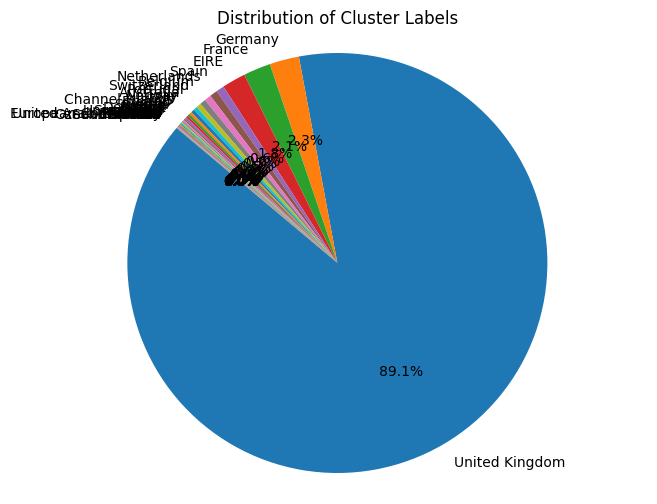

In [60]:
cluster_counts = df['Country'].value_counts()

# Plotting a pie chart based on the distribution of different cluster labels
plt.figure(figsize=(8, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Cluster Labels')
plt.show()